# Druggable Protein Classification (DPC)
### Mauricio Sandoval Cuenca

El proceso de desarrollo de fármacos implica una gran cantidad de etapas costosas y laboriosas en las que
es necesario un alto nivel de seguridad. Tı́picamente el punto de partida es la identificación de moléculas
objetivo (usualmente proteı́nas) sobre las cuales los fármacos puedan tener un efecto favorable. A esta
propiedad se le conoce como druggability.

A pesar de que se han usado diversos algoritmos basados en: Support Vector Machines, árboles de
decisión, ensemble of classifiers, regresión logı́stica, redes bayesianas, etc., para identificar la drogabilidad
de una molécula; las redes neuronales aún no han sido ampliamente exploradas para predecir cuando una
proteı́na objetivo puede emplearse efectivamente para diseñar fármacos.

En este trabajo exploramos las características de 5597 proteínas etiquetadas como positivas o negativas
e implementamos una red neuronal de aprendizaje profundo como clasificador usando `PyTorch`.

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Deep Learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Additional libraries
import seaborn as sns # Plotting heatmap of confusion matrix
from sklearn.preprocessing import StandardScaler  # Normalizing datasets
from sklearn.decomposition import PCA             # Principal Component Analysis
from sklearn.model_selection import train_test_split # Separate train and test sets
from sklearn import metrics # For testing the classification model

## Pre procesamiento
En el archivo `features_positives.txt` encontramos 39 características de distintas proteínas suceptibles a diseño de fármacos (que llamaremos positivas de ahora en adelante) obtenidas mediante métodos de dinámica molecular. En el archivo `features_negatives.txt` encontramos la misma información pero de proteínas no suceptibles a diseño de fármacos (a las que nos referiremos como negativas).

Dado que el número de número de muestras negativas es mucho mayor que el número de muestras positivas tendremos que recortar los datos negativos para balancear la base de datos. De otra manera, si entrenaramos a la red neuronal con datos imbalanceados sería muy probable que la red aprenda a clasificar todas las muestras como negativas, pues esto ofrece una probabilidad baja de error y devolvería un accuracy bastante alto sin embargo la red no está aprendiendo a identificar las proteínas positivas que es el principal objetivo.

Es importante recalcar que al recortar los datos estamos perdiendo información y más aún nos estamos quedamos con una base de datos pequeña lo que puede afectar el rendimiento de la red. Será necesario hacer las mismas pruebas con un número mayor de muestras para verificar mejores resultados.

In [2]:
# Cargamos los datos como dataframes de pandas para el pre procesamiento
# Recortamos el numero de datos negativos para que sea el mismo que el de positivos
positives = pd.read_csv('data/features_positives.txt', sep=" ", header=[0])
negatives = pd.read_csv('data/features_negatives.txt', sep=" ", header=[0], nrows=1128)

del positives['ID']
del negatives['ID']

features = positives.columns

# Añadimos las etiquetas (targets)
positives['label'] = 1
negatives['label'] = 0

In [3]:
# Unimos las muestras positivas y negativas
df = pd.merge(positives, negatives, how='outer')

# Revolvemos los datos y guadamos las etiquedas en otra variable
df = df.sample(frac=1).reset_index(drop=True)
labels = df['label']

print("Numero de caracteristicas: ", features.shape[0])

df.head()

Numero de caracteristicas:  39


,Pocket_Score,drug_score,tSASA,pSASA,aSASA,volume,nb_asph,apol_asph_proportion,mean_asph_radius,as_density,...,asn,pro,gln,arg,ser,thr,val,trp,tyr,label
0,0.4311,0.5965,111.892,47.255,64.638,485.7690,47,0.6596,3.8883,4.4579,...,0,1,1,0,1,1,0,1,3,0
1,0.3115,0.7994,131.212,55.131,76.081,430.1606,73,0.5479,3.7760,5.0148,...,1,0,0,1,0,1,0,1,0,0
2,0.0451,0.8357,182.788,51.651,131.136,555.7162,66,0.6061,4.1841,5.0368,...,1,1,3,1,2,0,1,2,1,0
3,-0.0263,0.0078,67.654,9.687,57.966,173.1944,15,0.4000,3.8962,1.4496,...,0,0,0,0,1,1,0,0,0,0
4,0.1259,0.3645,167.110,65.669,101.441,586.5621,50,0.6000,4.0669,4.5934,...,0,1,0,0,0,2,2,1,0,0


In [4]:
# Para mas informacion sobre las caracteristicas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Pocket_Score          2256 non-null   float64
 1   drug_score            2256 non-null   float64
 2   tSASA                 2256 non-null   float64
 3   pSASA                 2256 non-null   float64
 4   aSASA                 2256 non-null   float64
 5   volume                2256 non-null   float64
 6   nb_asph               2256 non-null   int64  
 7   apol_asph_proportion  2256 non-null   float64
 8   mean_asph_radius      2256 non-null   float64
 9   as_density            2256 non-null   float64
 10  mean_asph_solv_acc    2256 non-null   float64
 11  mean_loc_hyd_dens     2256 non-null   float64
 12  flex                  2256 non-null   float64
 13  hydrophobicity_score  2256 non-null   float64
 14  volume_score          2256 non-null   float64
 15  charge_score         

### Normalización

Procedemos a normalizar los datos extrayendo la media y dividiendo entre la desviación estándar

In [5]:
# Seleccionamos unicamente los datos sin etiquetas
norm_data = df.loc[:, features]

# Normalizamos
norm_data = StandardScaler().fit_transform(norm_data)

#print(norm_data)
print('Media: ', np.mean(norm_data))
print('Varianza: ', np.std(norm_data))

Media:  -7.429752192436035e-17
Varianza:  0.9999999999999999


Regresamos los datos normalizados a un dataframe para continuar con el pre procesamiento

In [6]:
norm_df = pd.DataFrame(norm_data, columns=features)
norm_df.head()

,Pocket_Score,drug_score,tSASA,pSASA,aSASA,volume,nb_asph,apol_asph_proportion,mean_asph_radius,as_density,...,met,asn,pro,gln,arg,ser,thr,val,trp,tyr
0,1.470478,0.305448,-0.815238,-0.568176,-0.872761,-0.611754,-0.762722,0.692753,-0.650702,-0.583542,...,-0.156654,-0.822046,0.132769,-0.300265,-0.612063,-0.121392,0.024610,-0.687238,-0.213894,1.101102
1,0.812191,0.870192,-0.666622,-0.439499,-0.732500,-0.725921,-0.337559,0.130500,-1.709005,-0.339371,...,0.788298,0.073865,-0.830342,-1.019373,0.434008,-0.917501,0.024610,-0.687238,-0.213894,-1.119476
2,-0.654094,0.971228,-0.269882,-0.496355,-0.057670,-0.468148,-0.452026,0.423455,2.136884,-0.329725,...,0.315822,0.073865,0.132769,1.137949,0.434008,0.674716,-0.816602,0.456975,0.537734,-0.379283
3,-1.047085,-1.333118,-1.155532,-1.181959,-0.954542,-1.253486,-1.285999,-0.613970,-0.576254,-1.902521,...,-0.156654,-0.822046,-0.830342,-1.019373,-0.612063,-0.121392,0.024610,-0.687238,-0.965523,-1.119476
4,-0.209365,-0.340292,-0.390483,-0.267330,-0.421653,-0.404820,-0.713665,0.392750,1.032404,-0.524132,...,-0.629131,-0.822046,0.132769,-1.019373,-0.612063,-0.917501,0.865822,1.601188,-0.213894,-1.119476


### Correlación
Visualizamos la matriz de correlación de las características de nuestro dataframe con el objetivo de identificar si hay redundancia en la información

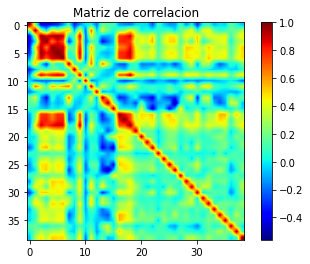

In [7]:
# Calculamos la matriz de correlacion
correlation = norm_df.corr()

# Realizamos un heatmap de la matriz de correlacion
figure, axes = plt.subplots()
c = axes.imshow(correlation, cmap='jet', interpolation='bilinear')
axes.set_title('Matriz de correlacion')
figure.colorbar(c)
#plt.savefig("img/correlation_matrix.jpg")

Imprimimos aquellos features que tienen una correlación alta (arriba de 0.9)

In [8]:
for n in range(features.size):
    for m in range(n):
        if correlation.iloc[n, m] >= 0.9:
            print(features[n], features[m])

aSASA tSASA
volume tSASA
volume aSASA
nb_asph tSASA
nb_asph volume
as_density tSASA
as_density volume
COM_minus_asphr_max volume
COM_minus_asphr_max as_density


Podemos observar que en efecto exite cierto número de features que guardan una relación estrecha entre sí, esto es, guardan la misma cantidad de información y por lo tanto no son indispensables. Para reducir la dimensionalidad, eliminando redundancias y optimizando el entrenamiento, hemos optado por usar el método de Principal Component Analysis como se muestra a continuación.

### Reducción de la dimensión vía PCA
Ya que hemos notado que exite redundancia en la información será pertinente que usaremos Principal Component Analysis (PCA) para disminuir la dimensión

Fuente  
https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python

In [9]:
# Definimos el modelo de manera que conserve el 0.9 de la variacion total de la informacion
pca = PCA(0.9)

# Ajustamos los datos normalizados al modelo
principalComponents = pca.fit_transform(norm_data)

# Devolvemos los componentes principales a un data frame
column_names = ['pc %d' % i for i in range(1, pca.n_components_+1)]
pca_df = pd.DataFrame(principalComponents, columns=column_names)
pca_df.head()

,pc 1,pc 2,pc 3,pc 4,pc 5,pc 6,pc 7,pc 8,pc 9,pc 10,pc 11,pc 12,pc 13,pc 14,pc 15,pc 16,pc 17,pc 18,pc 19,pc 20
0,-2.206285,0.688700,-0.560968,-2.397359,-0.458798,-0.445394,1.002086,1.412269,-1.057081,-0.055358,-1.102080,0.709880,-0.591666,0.278477,0.360324,0.036680,0.686853,-0.025479,-0.193032,0.082530
1,-1.292663,0.179560,0.186536,-1.039083,-2.777708,1.841242,0.559203,-0.186097,-0.307815,-0.001811,0.375598,-0.314831,2.290798,-1.281711,-0.370092,-0.642621,-1.201599,-0.636954,0.038152,0.682237
2,-0.874532,1.534501,0.416738,2.488008,-0.006750,-0.695969,-0.378499,-0.784919,-0.070170,0.928329,0.860334,0.550238,0.276379,0.035463,1.513277,-0.241528,-0.155820,0.087147,-0.769542,-0.747889
3,-5.267327,-1.097933,-0.650356,0.715475,-1.113221,-2.008872,0.954428,0.844654,-0.431907,-0.242861,-0.272014,-1.028687,0.118507,-0.509827,-0.611417,-0.626812,0.204047,-0.156926,0.419322,-0.427383
4,-1.974030,0.398814,0.497221,0.883716,0.805015,-2.199575,2.303392,-0.772891,0.787298,0.089087,-0.276762,-0.613755,1.329577,0.179324,-1.556843,-1.111410,-1.216084,0.174477,0.183530,0.526576


In [10]:
num_components = pca.n_components_

print('Numero de componentes: ', num_components)
print('Varinza por componente principal: ', pca.explained_variance_ratio_, sep='\n')
print('Varianza total: ', pca.explained_variance_ratio_.sum())

Numero de componentes:  20
Varinza por componente principal: 
[0.29893057 0.11732232 0.06316021 0.04519905 0.04045637 0.03467608
 0.03040925 0.02772032 0.02695732 0.02462544 0.02283878 0.02155009
 0.02144623 0.02077524 0.02021135 0.01867273 0.01827413 0.01706756
 0.01569721 0.0154325 ]
Varianza total:  0.9014227562858543


Hemos reducido la dimensión de 39 características a 21 componentes principales, con lo que hemos mantenido el 91.12% de la información total.

Finalmente, regresamos las etiquetas al dataframe y lo descargamos como un nuevo archivo .txt que contendrá los datos que aplicaremos a la red neuronal

In [11]:
proc_df = pca_df
proc_df['label'] = labels
proc_df.to_csv('data/pocket_features_summary.txt', sep=' ', index=False) 

### Conjuntos de entrenamiento y prueba

In [12]:
# Cargamos el data frame que usaremos
data = pd.read_csv('data/pocket_features_summary.txt', sep=" ", header=[0])

# Separamos los datos en un conjunto de entrenamiento con un 80% de los datos y conjunto de prueba con el resto
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Guardamos nuevamente en archivos .csv para despues transformarlos en data loaders de pytorch
X_train.to_csv('train_features.csv', index=False)
y_train.to_csv('train_labels.csv', index=False)

X_test.to_csv('test_features.csv', index=False)
y_test.to_csv('test_labels.csv', index=False)

Definimos una clase auxiliar que nos ayudará a pasar nuestros datos a dataloaders de pytorch para simplificar el trabajo.

Fuente  
https://rasbt.github.io/coral_pytorch/tutorials/poker/

In [13]:
from torch.utils.data import Dataset

class MyDataset(Dataset):

    def __init__(self, csv_path_features, csv_path_labels, dtype=np.float32):

        self.features = pd.read_csv(csv_path_features).values.astype(np.float32)
        self.labels = pd.read_csv(csv_path_labels).values.flatten()

    def __getitem__(self, index):
        inputs = self.features[index]
        label = self.labels[index]
        return inputs, label

    def __len__(self):
        return self.labels.shape[0]

In [14]:
from torch.utils.data import DataLoader

# Aplicaremos los datos pre procesados en minibatches de tamaño 200
batch_size = 200

train_dataset = MyDataset('train_features.csv', 'train_labels.csv')
test_dataset = MyDataset('test_features.csv', 'test_labels.csv')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0) # number processes/CPUs to use

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=0) # number processes/CPUs to use

In [15]:
# Exploration of data before training
for data in train_loader:
    print(data)
    break

[tensor([[-1.7502,  2.0184,  0.0846,  ..., -0.3880, -0.4588,  0.5863],
        [-2.1496,  4.8077, -0.4278,  ..., -0.4199, -0.0543, -0.7474],
        [-4.5306, -2.0059, -0.6971,  ...,  0.0102,  0.7541, -0.6870],
        ...,
        [ 3.6546, -2.3462,  1.7380,  ...,  0.5961, -0.4094,  1.3917],
        [ 0.5072,  2.3160,  1.1170,  ..., -1.1058, -0.9168,  0.5145],
        [-0.3650, -1.2034,  1.4982,  ...,  0.3607,  0.7657, -1.1030]]), tensor([1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
    

## Arquitectura de la Red

Definimos una red de aprendizaje profundo conformada por:

1. capa de entrada con tamaño igual a la dimensión obtenida después de aplicar PCA
2. capas ocultas completamente conectadas mediante ReLU una de tamaño 13 y otra de tamaño 8 (2/3 de la capa anterior)
3. capa de salida con dos nodos seguida de la función log softmax

Para el entrenamiento tomaremos un total de 10000 iteraciones, usaremos entropía cruzada como función de pérdida y como optimizador usaremos el algoritmo de Adam con $\alpha = 0.001$. Después graficaremos la función de pérdida respecto al conjunto de entrenamiento. Finalmente, con el conjunto de prueba evaluaremos el rendimiento de nuestra red.

In [16]:
class DPC_NET(nn.Module):
    def __init__(self):
        '''
        Construcción de la arquitectura de la Red
        '''
        super(DPC_NET, self).__init__()
        self.fc1 = nn.Linear(num_components, 13)
        self.fc2 = nn.Linear(13, 8)
        self.fc3 = nn.Linear(8, 2)
        
    
    def forward(self, x):
        '''
        Definicion del orden con el que se realizará la propagación hacia adelante
        de la red.
        '''
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

## Entrenamiento

Cargamos el modelo si ya fue guardado

In [17]:
try:
    std_dict = torch.load('./dpc_net.pth', map_location=torch.device("cpu"))
    net.load_state_dict(std_dict)
    print("Modelo cargado.")
except:
    print("Modelo nuevo.")

Modelo nuevo.


In [18]:
# Inicalizamos el modelo y las funciones necesarias para el entrenamiento.
net = DPC_NET()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

iterations = 10000

loss_array = np.array([])

for epoch in range(iterations):  # loop over the complete dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    loss_array = np.append(loss_array, running_loss)

    
final_loss = loss_array[-1]
print('Final loss: %.2f' % final_loss)

torch.save(net.state_dict(), "./dpc_net.pth")
print("Modelo Guardado")

print('Finished Training')

Final loss: 3.70
Modelo Guardado
Finished Training


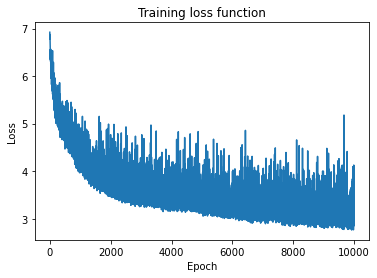

In [19]:
# Graficamos la funcion de perdida durante el entrenamiento

plt.plot(loss_array)
plt.title('Training loss function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Pruebas

Ya que el objtivo de esta red es poder identificar aquellas muestras con una etiqueta en específico, el accuracy (la proporción de datos bien clasificados) no resulta ser la mejor medida. En este caso el recall y el precision nos darán una mejor evaluación de la clasificación, recordemos que

1. _recall_ mide la habilidad del clasificador de encontrar todas las muestras positivas, mientras que
2. _precision_ mide la habilidad de no clasificar como positiva una muestra que es negativa

más aún nosotros tomaremos como principal medida de evaluación el AUC que es el área debajo de la curva ROC. La curva ROC es una medida que sintetiza las características del recall y el precision y su área toma valores entre 0 y 1, siendo los valores cercanos a 1 los mejores. Tomaremos el AUC como referencia para compara los resultados de otros modelos de clasificación presentados en la referencia [1].

AUC : 0.6039823008849557


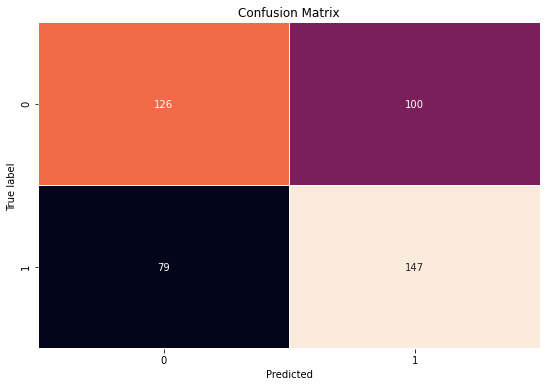

In [22]:
# Pasamos los datos de prueba por la red para obtener las predicciones
y_true = torch.tensor([])
outputs = torch.tensor([])

for data, labels in test_loader:
    y_true = torch.cat((y_true, labels), 0)
    outputs = torch.cat((outputs, net(data)), 0)
    
_, y_pred = torch.max(outputs, 1)

# Calculamos la matiz de confusion y otras medidas de evaluacion
auc = metrics.roc_auc_score(y_true, y_pred)
conf_mat = metrics.confusion_matrix(y_true, y_pred)

print('AUC :', auc)

# Hacemos un plot de la matrix de confusion
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cbar=False, linewidths=.5, ax=ax)

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('True label')

plt.show()

## Conclusiones

En la referencia [1] encontramos una síntesis del trabajo elaborado al rededor de la predicción de la drogabilidad de las proteínas. A pesar de que los métodos obtenidos para extraer las características de las proteínas en este trabjo son distintas a las presentadas en el artículo [1], podemos hacer una comparación para darnos una idea del rendimiento de distintos modelos y comparar con los resultados obtenidos por nuestra red neuronal. A continuación mostramos los resultados de aplicar algunos modelos de clasificación clásicos tomando como medida de referencia el AUC

| Algoritmo               | AUC    |
|-------------------------|--------|
| Support Vector Machines | 69.21% |
| Logistic Regression     | 63.27% |
| Decision Tree           | 82 %   |
| Rank-based method       | 76 %   |

Como podemos ver, el rendimiento de nuestra red neuronal se puede considerar aceptable pero no supera a ninguno de los métodos clásicos. Más aún, comparando el costo computacional podríamos pensar que las redes de aprendizaje profundo no son el mejor modelo a considerar al momento de realizar un trabajo de clasificación. Sin embargo, será necesario probar la evaluación de distintas características como las extraídas a partir de la biología de sistemas para corroborar el rendimiento de las redes neuronales. 

Otro factor que tenemos que considerar es que en este caso nos vimos forzados a trabajar con una base de datos pequeña con la finalidad de balancear el tamaño de las muestras positivas y negativas. 

Referencias

1. Kandoi G, Acencio ML and Lemke N (2015) _Prediction of Druggable Proteins Using Machine Learning and Systems Biology: A Mini-Review._ Front. Physiol. 6:366. doi: 10.3389/fphys.2015.00366

2.  Jamali, A.A., Ferdousi, R., Razzaghi, S., Li, J., Safdari, R., Ebrahimie, E., _DrugMiner: comparative analysis of machine-learning algorithms for prediction of potential druggable proteins_, Drug Discovery Today (2016), http://dx.doi.org/10.1016/j.drudis.2016.01.007